In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets
import torch.optim as optim
import copy

In [31]:
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [32]:
def one_hot_transform(labels):
    one_hot = torch.zeros(labels.size()+tuple([10])).scatter_(-1, labels, 1)
    return one_hot

In [33]:
trainset = datasets.MNIST(root='../data',
                          train = True,
                          download = True,
                          transform = transforms.Compose([
                              transforms.RandomCrop(28, 2), 
                              transforms.ToTensor()]),
                          target_transform = one_hot_transform)

testset = datasets.MNIST(root='../data',
                         train = False,
                         download = True,
                         transform = transforms.Compose([
                             transforms.ToTensor()]),
                         target_transform = one_hot_transform)

In [34]:
train_loader = torch.utils.data.DataLoader( trainset, batch_size = 128, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader( testset, batch_size = 128, shuffle = False, num_workers = 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations = 3):
        super(CapsuleLayer, self).__init__()
        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations
        self.num_capsules = num_capsules
        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)
      
    def softmax(self, tensor, dim = 1):
        transposed_input = tensor.transpose(dim, len(tensor.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(tensor.size()) - 1)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
        
            logits = torch.zeros(*priors.size()).to(device)
            for i in range(self.num_iterations):
                probs = self.softmax(logits, dim = 2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)
        return outputs

In [36]:
class CapsuleNetDecoder(nn.Module):
    def __init__(self):
        super(CapsuleNetDecoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 256, kernel_size = 9, stride = 1)
        self.primary_capsules = CapsuleLayer(num_capsules = 8, num_route_nodes = -1, in_channels = 256, out_channels = 32,
                                             kernel_size = 9, stride = 2)
        self.digit_capsules = CapsuleLayer(num_capsules = 10, num_route_nodes = 32 * 6 * 6, in_channels = 8,
                                           out_channels = 16)

        self.decoder = nn.Sequential(nn.Linear(16 * 10, 512),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, 1024),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(1024, 784),
                                     nn.Sigmoid())

    def forward(self, x, y, recons = True):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
        classes = (x**2).sum(dim=-1)**0.5
        classes = F.softmax(classes, dim=-1)
        reconstructions = None
        if (recons):
            reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return x, classes, reconstructions

In [37]:
class CapsLoss(nn.Module):
  
    def __init__(self):
        super(CapsLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average = False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace = True) ** 2
        right = F.relu(classes - 0.1, inplace = True) ** 2
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [38]:
criterion = CapsLoss()
net = CapsuleNetDecoder().to(device) #for GPU
optimizer = optim.Adam(net.parameters(), lr = 0.001)
start_epoch = 0

for epoch in range(15):  # Set no. of epochs to 15

    # training
    net.train()
    running_loss = 0.0
    count = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x, outputs, reconst = net(inputs, labels)
        loss = criterion(inputs, labels, outputs, reconst)
        
        loss.backward()
        optimizer.step()

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) # Multiply by batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) # Accuracy
    
    print("With recons epoch no.: %d, Train loss: %.5f, Training Accuracy is: %.5f " % (epoch + 1, running_loss/len(trainset), count/len(trainset)) )
    
    # testing
    net.eval()
    running_loss = 0.0
    count = 0.0
    for data in test_loader:
        # get the inputs
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward 
        with torch.no_grad():
            x, outputs, reconst = net(inputs, labels)
        loss = criterion(inputs, labels, outputs, reconst)

        # statistics
        running_loss +=  ( loss.item() * inputs.size(0)) # Multiply by batch size
        count += sum(np.argmax(labels.data.cpu().numpy(), 1) == np.argmax(outputs.data.cpu().numpy(), 1)) # Accuracy
        
    print("With recons epoch no.: %d, Test loss: %.5f, Testing Accuracy is: %.5f " % (epoch + 1, running_loss/len(testset), count/len(testset)) )

With recons epoch no.: 1, Train loss: 0.51928, Training Accuracy is: 0.89840 
With recons epoch no.: 1, Test loss: 0.47885, Testing Accuracy is: 0.98510 
With recons epoch no.: 2, Train loss: 0.48123, Training Accuracy is: 0.97833 
With recons epoch no.: 2, Test loss: 0.47343, Testing Accuracy is: 0.98990 
With recons epoch no.: 3, Train loss: 0.47546, Training Accuracy is: 0.98410 
With recons epoch no.: 3, Test loss: 0.47050, Testing Accuracy is: 0.99030 
With recons epoch no.: 4, Train loss: 0.47196, Training Accuracy is: 0.98778 
With recons epoch no.: 4, Test loss: 0.46750, Testing Accuracy is: 0.99340 
With recons epoch no.: 5, Train loss: 0.46970, Training Accuracy is: 0.98783 
With recons epoch no.: 5, Test loss: 0.46635, Testing Accuracy is: 0.99270 
With recons epoch no.: 6, Train loss: 0.46794, Training Accuracy is: 0.98992 
With recons epoch no.: 6, Test loss: 0.46539, Testing Accuracy is: 0.99160 
With recons epoch no.: 7, Train loss: 0.46648, Training Accuracy is: 0.99088

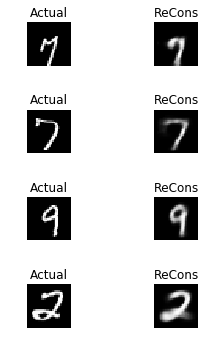

In [40]:
plot_loader = torch.utils.data.DataLoader( trainset, batch_size = 4, shuffle = True, num_workers = 4)
net.eval() # Evaluating

for data in plot_loader:
    # get the inputs
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # forward + backward + optimize
    x, outputs, reconst = net(inputs, labels)

    break #just take the 4 examples

X = np.asarray(inputs.data).astype(np.float32)

X_recons = np.asarray(reconst.data.view(-1,28,28)).astype(np.float32)


for i in range(X.shape[0]):
    plt.subplot(X.shape[0], 2, 2*i+1)
    plt.imshow(X[i][0], cmap = 'gray')
    plt.title('Actual')
    plt.axis('off')
    
    plt.subplot(X.shape[0], 2, 2*i+2)
    plt.imshow(X_recons[i], cmap = 'gray')
    plt.title("ReCons")
    plt.axis('off')
    
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.gcf().set_size_inches(5, 5)
    plt.tight_layout()
plt.show()

# References

This code is taken from [this](https://github.com/gram-ai/capsule-networks) excellent repository and changes are made so that the reconstruction of images and the capsule dimension experiment is also performed. 